In [8]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path_data_DCO = "/Users/eresther/Documents/Work/PhD/Codes/Data_DCO"
path_data_PSTH = "/Users/eresther/Documents/Work/PhD/Codes/Data_PSTH"

AREAS = ["A1", "dPEG", "VPr", "PFC"]
CTXS = ["a", "p"]
STIMS = ["R", "N"]
TASKS_STIMS = {"R": "PTD", "N": "CLK"}
training = True

In [3]:
W = {area: None for area in AREAS}
for area in AREAS:
    W[area] = xr.open_dataarray(f"{path_data_DCO}/Wt_{training}_{area}.nc")

W = {area: None for area in AREAS}
for area in AREAS:
    W[area] = xr.open_dataarray(f"{path_data_DCO}/W_{training}_{area}.nc")

X = {area: None for area in AREAS}
for area in AREAS:
    X[area] = xr.open_dataarray(f"{path_data_PSTH}/Z_{training}_{area}_valid.nc")

In [6]:
# Define useful variables
print(W['A1']['set_sizes'].values)
ntpts = len(X['A1']['time'].values)
nfolds = W['A1'].attrs['k']

def get_nbatches(area):
    return len(W[area]['batches'].values)

print(ntpts, nfolds, get_nbatches("A1"))


[24 24]
38 3 2


In [7]:
# Keep true models and relevant decoders
W_ = {area: W[area].sel(decoders='task-a_bl/p_bl', models='true') for area in AREAS}

W_['A1']

<xarray.DataArray 'W' (units: 26, time: 1, folds: 3, batches: 2)> Size: 1kB
[156 values with dtype=float64]
Coordinates: (12/14)
  * units      (units) <U10 1kB 'lem046d-j1' 'avo047a-u1' ... 'lem045c-p1'
  * time       (time) <U3 12B 'wdw'
    decoders   <U22 88B 'task-a_bl/p_bl'
  * folds      (folds) <U7 84B 'train_0' 'train_1' 'train_2'
    models     <U7 28B 'true'
  * batches    (batches) int64 16B 0 1
    ...         ...
    task1      <U3 12B ...
    ctx1       <U1 4B ...
    stim1      <U1 4B ...
    task0      <U3 12B ...
    ctx0       <U1 4B ...
    stim0      <U1 4B ...
Attributes:
    area:      A1
    training:  1
    errors:    0
    k:         3
    windows:   1

In [14]:
# Compute projections of the activity in each condition onto the decoders
P = {area: {ctx: {stim: np.full((ntpts, nfolds, get_nbatches(area)), fill_value=np.nan) for stim in STIMS} for ctx in CTXS} for area in AREAS}
STD = {area: {ctx: {stim: np.full((ntpts, nfolds, get_nbatches(area)), fill_value=np.nan) for stim in STIMS} for ctx in CTXS} for area in AREAS}
SEM = {area: {ctx: {stim: np.full((ntpts, nfolds, get_nbatches(area)), fill_value=np.nan) for stim in STIMS} for ctx in CTXS} for area in AREAS}

for area in AREAS:
    for f in range(nfolds):
        for b in range(get_nbatches(area)):
            print(f"*** Area: {area}, Fold: {f}, Batch: {b} ***")
            w = W_[area].sel(folds=f'train_{f}', batches=b).values.flatten() # (nunits, ntpts)
            print(f"Shape W: {w.shape}")
            # Display the number of nan among all the values of the decoders (it suffices to check the first time point)
            print(f"Number of NaN weights (units): {np.sum(np.isnan(w))} / {w.shape[0]}") # w.shape[0] is the number of units
            X_area = X[area].sel(trials=X[area][f'test_{f}'].values) # retain the right test fold (nunits, ntpts, ntrials_test_fold_f)
            for s in STIMS:
                t = TASKS_STIMS[s]
                for c in CTXS:
                    print(f"-- Task: {t}, Context: {c}, Stimulus: {s}")
                    x = X_area.sel(trials=(X_area['task'].values==t)&(X_area['ctx'].values==c)&(X_area['stim'].values==s)).values # (nunits, ntpts, ntrials_condition)
                    print(f"   Shape X: {x.shape}")
                    # Display the number of NaN among all the values of the activity
                    print(f"   Number of NaN activity: {np.sum(np.isnan(x))} / {np.prod(x.shape)}") # np.prod(x.shape) is the total number of values in x
                    # Compute the dot product (add a new axes to w to broadcast)
                    product = w[:,np.newaxis,np.newaxis] * x # (nunits, ntpts, ntrials_condition)
                    dot = np.nansum(product, axis=0) # sum across units -> (ntpts, ntrials_condition)
                    # Check again the number of NaNs : if the number of NaN is 0 in x, it should be 0 in dot
                    print(f"   Number of NaN dot product: {np.sum(np.isnan(dot))} / {np.prod(dot.shape)}")
                    # Compute the trial averaged activity
                    P[area][c][s][:, f, b] = np.nanmean(dot, axis=1)
                    # Check the number of NaN in the trial averaged activity
                    print(f"   Number of NaN trial averaged activity: {np.sum(np.isnan(P[area][c][s][:, f, b]))} / {P[area][c][s][:, f, b].size}")
                    # Compute the std across trials
                    STD[area][c][s][:, f, b] = np.nanstd(dot, axis=1)
                    # Compute the SEM across trials
                    SEM[area][c][s][:, f, b] = STD[area][c][s][:, f, b] / np.sqrt(x.shape[2])
            print("------------")

*** Area: A1, Fold: 0, Batch: 0 ***
Shape W: (26,)
Number of NaN weights (units): 2 / 26
-- Task: PTD, Context: a, Stimulus: R
   Shape X: (26, 38, 5)
   Number of NaN activity: 0 / 4940
   Number of NaN dot product: 0 / 190
   Number of NaN trial averaged activity: 0 / 38
-- Task: PTD, Context: p, Stimulus: R
   Shape X: (26, 38, 5)
   Number of NaN activity: 0 / 4940
   Number of NaN dot product: 0 / 190
   Number of NaN trial averaged activity: 0 / 38
-- Task: CLK, Context: a, Stimulus: N
   Shape X: (26, 38, 5)
   Number of NaN activity: 2080 / 4940
   Number of NaN dot product: 0 / 190
   Number of NaN trial averaged activity: 0 / 38
-- Task: CLK, Context: p, Stimulus: N
   Shape X: (26, 38, 5)
   Number of NaN activity: 2080 / 4940
   Number of NaN dot product: 0 / 190
   Number of NaN trial averaged activity: 0 / 38
------------
*** Area: A1, Fold: 0, Batch: 1 ***
Shape W: (26,)
Number of NaN weights (units): 2 / 26
-- Task: PTD, Context: a, Stimulus: R
   Shape X: (26, 38, 5)
 

In [18]:
# Average results across folds and batches to keep only the time dimension (axis 0)
P_avg = {area: {ctx: {stim: np.nanmean(P[area][ctx][stim], axis=(1,2)) for stim in STIMS} for ctx in CTXS} for area in AREAS}
STD_avg = {area: {ctx: {stim: np.nanmean(STD[area][ctx][stim], axis=(1,2)) for stim in STIMS} for ctx in CTXS} for area in AREAS}
SEM_avg = {area: {ctx: {stim: np.nanmean(SEM[area][ctx][stim], axis=(1,2)) for stim in STIMS} for ctx in CTXS} for area in AREAS}

print(P_avg['A1']['a']['R'].shape)
print(P_avg['A1']['a']['N'].shape)

(38,)
(38,)


In [19]:
# Define colors and linestyles
colors = {'a': {'R': 'blue', 'N': 'k'}, 'p': {'R': 'navy', 'N': 'gray'}}
linestyles = {'a': '-', 'p': '--'}

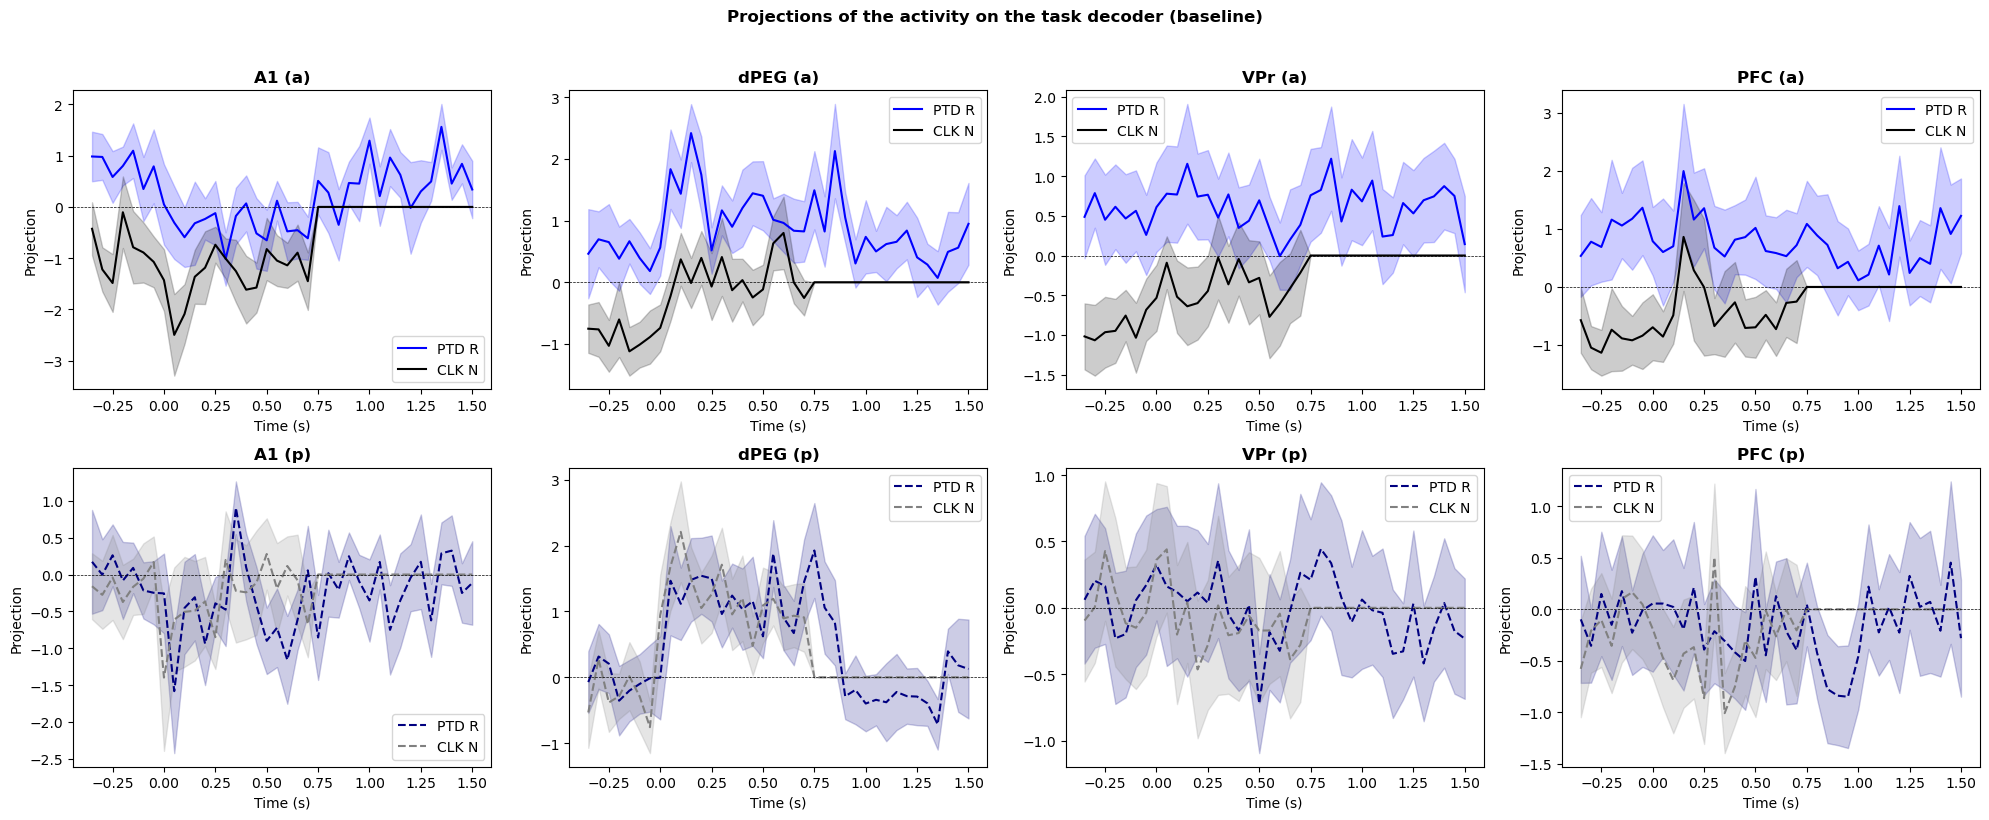

In [21]:
# FIG1: Time courses
nrows = len(CTXS)
ncols = len(AREAS)


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
fig.suptitle("Projections of the activity on the task decoder (baseline)", weight='bold', y=1.02)

for i, ctx in enumerate(CTXS):
    for j, area in enumerate(AREAS):
        ax = axes[i, j]
        for s in STIMS:
            t = TASKS_STIMS[s]
            ax.plot(X[area]['time'].values, P_avg[area][ctx][s], color=colors[ctx][s], linestyle=linestyles[ctx], label=f"{t} {s}")
            ax.fill_between(X[area]['time'].values, P_avg[area][ctx][s]-SEM_avg[area][ctx][s], P_avg[area][ctx][s]+SEM_avg[area][ctx][s], color=colors[ctx][s], alpha=0.2)
        ax.set_title(f"{area} ({ctx})", weight='bold')
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Projection")
        ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
        ax.legend()

plt.tight_layout()
plt.show()